In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# External imports 2
from sklearn import linear_model, svm, ensemble
from sklearn import dummy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, make_scorer

In [44]:
# Internal imports
import importlib
import extraction as ex
import features as feat
ex = importlib.reload(ex)
feat = importlib.reload(feat)

In [172]:
# Small tables
train = ex.read_train()
test = ex.read_test()
useful_msno = set.union(
    set(train.index.unique()),
    set(test.index.unique())
)
members = ex.read_members()


READING TRAIN


Memory usage (MB) : 8.33381652832
Index       7.407837
is_churn    0.925980
dtype: float64


READING TEST


Memory usage (MB) : 6.92345428467
Index    6.923454
dtype: float64


READING MEMBERS


Memory usage (MB) : 135.57332325
Index                     51.646980
city                       6.455873
bd                        12.911745
gender                     6.455873
registered_via             6.455873
registration_init_time    51.646980
dtype: float64



In [175]:
# Big tables
transactions = ex.read_transactions(useful_msno=None, max_lines=10**9, chunksize=10**6)
user_logs = ex.read_user_logs(useful_msno=None, max_lines=10**7, chunksize=10**6, just_date=True)


READING TRANSACTIONS

Chunk 1 of transactions read
Chunk 2 of transactions read
Chunk 3 of transactions read
Chunk 4 of transactions read
Chunk 5 of transactions read
Chunk 6 of transactions read
Chunk 7 of transactions read
Chunk 8 of transactions read
Chunk 9 of transactions read
Chunk 10 of transactions read
Chunk 11 of transactions read
Chunk 12 of transactions read
Chunk 13 of transactions read
Chunk 14 of transactions read
Chunk 15 of transactions read
Chunk 16 of transactions read
Chunk 17 of transactions read
Chunk 18 of transactions read
Chunk 19 of transactions read
Chunk 20 of transactions read
Chunk 21 of transactions read
Chunk 22 of transactions read
Chunk 23 of transactions read
Chunk 24 of transactions read

Memory usage (MB) : 898.484187126
Index                     175.313988
msno                      175.313988
payment_method_id          21.914248
payment_plan_days          43.828497
plan_list_price            43.828497
actual_amount_paid         43.828497
is_auto_r

In [177]:
transactions["transaction_date"].max()

Timestamp('2017-03-31 00:00:00')

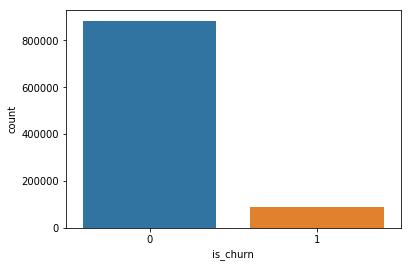

In [10]:
# Analysis of train

sns.countplot(x="is_churn", data=train)
plt.show()

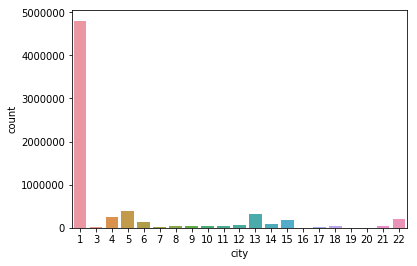

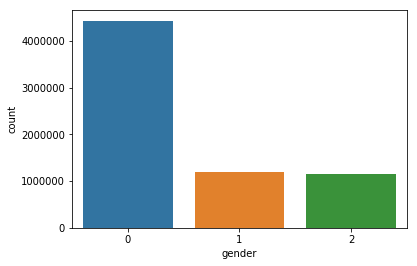

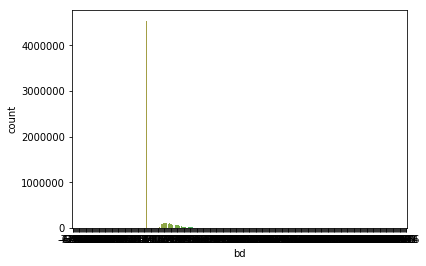

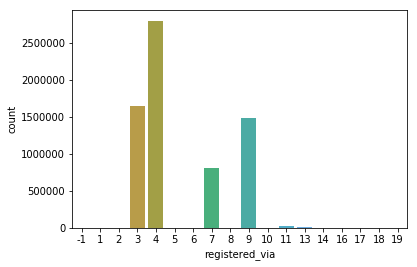

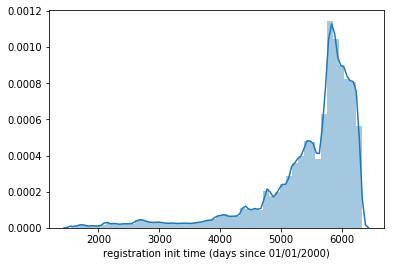

In [19]:
# Analysis of members

for c in ["city", "gender", "bd", "registered_via"]:
    sns.countplot(x=c, data=members)
    plt.show()

sns.distplot(feat.count_days(members["registration_init_time"]))
plt.xlabel("registration init time (days since 01/01/2000)")
plt.show()

In [181]:
members["registration_init_days"] = feat.count_days(members["registration_init_time"])

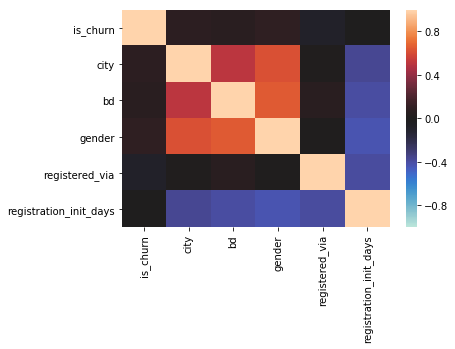

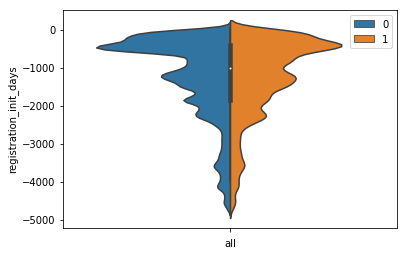

In [190]:
# Exploring variable influence for members

data=train.join(members, how="inner")
data["all"] = ""

sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0)
plt.show()

sns.violinplot(hue="is_churn", x="all", y="registration_init_days", data=data, split=True)
plt.legend(loc="best")
plt.show()

In [6]:
# For train set, pretend we don't know what happens in March
transactions = transactions[transactions["transaction_date"] < pd.Timestamp(2017, 3, 1)]
user_logs = user_logs[user_logs["date"] < pd.Timestamp(2017, 3, 1)]

In [21]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0


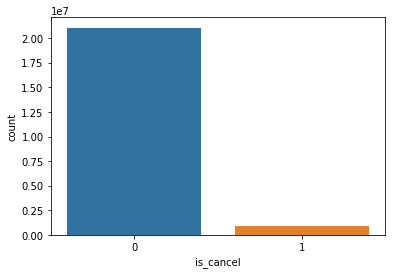

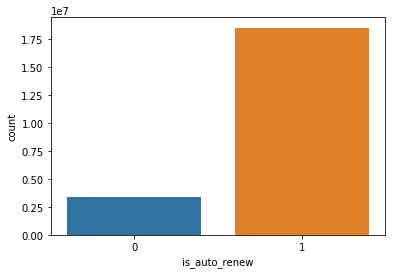

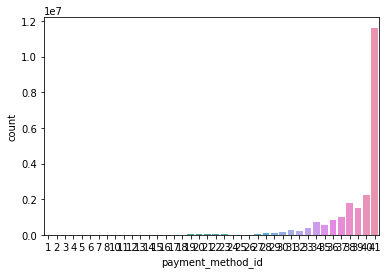

In [24]:
# Analysis of transactions

for c in ["is_cancel", "is_auto_renew", "payment_method_id"]:
    sns.countplot(x=c, data=transactions)
    plt.show()

In [110]:
# Registration init
registration_init = feat.count_days(members["registration_init_time"])

In [111]:
members_data = pd.DataFrame(index=members.index)
members_data["registration_init_time"] = registration_init

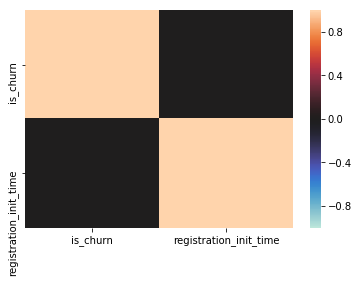

In [112]:
# Exploring variable influence for transactions

data=train.join(members_data, how="inner")
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0)
plt.show()

In [155]:
transactions.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_duration
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0,32
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0,31
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0,210
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0,59
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0,52


In [159]:
# Grouping transactions
grouped_trans = transactions.groupby("msno")
trans_msno = grouped_trans.max().index

In [195]:
# Latest transaction
latest_trans = feat.count_days(grouped_trans["transaction_date"].max())
# Planned expiration
expiration = feat.count_days(grouped_trans["membership_expire_date"].max())
# Transaction duration
trans_dur = grouped_trans["payment_plan_days"].mean()
# Auto-renew
auto_renew_freq = grouped_trans["is_auto_renew"].mean()
# Cancel
cancel_freq = grouped_trans["is_cancel"].mean()
# Total price
total_price = grouped_trans["actual_amount_paid"].sum()
# Payment method
# payment_method = grouped_trans["payment_method_id"].agg(lambda x:x.value_counts().index[0])

In [196]:
transactions_data = pd.DataFrame(index=trans_msno)
transactions_data["Latest_transaction"] = latest_trans
transactions_data["Planned_membership_expiration"] = expiration
transactions_data["Mean_transaction_duration"] = trans_dur
transactions_data["Auto_renew_freq"] = auto_renew_freq
transactions_data["Cancel_freq"] = cancel_freq
transactions_data["Total_price"] = total_price
# transactions_data["Payment_method"] = payment_method

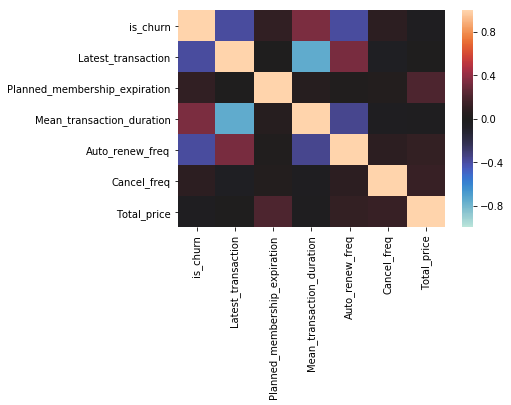

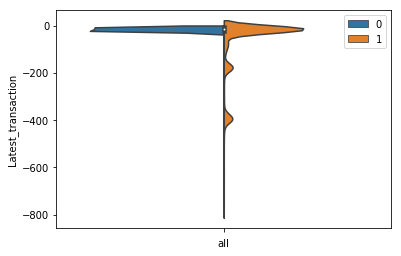

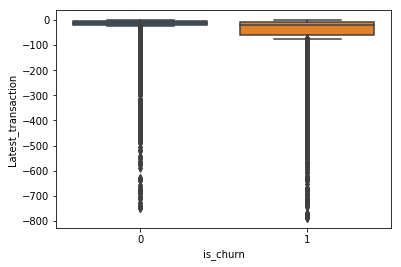

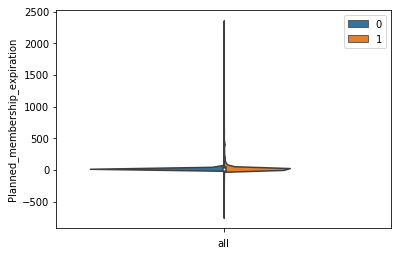

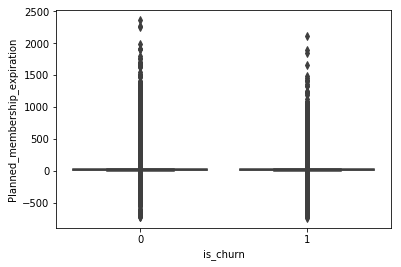

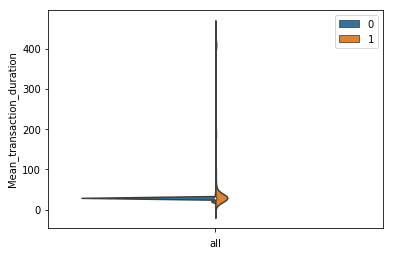

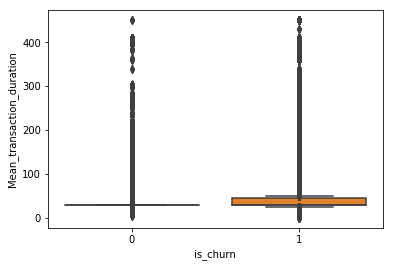

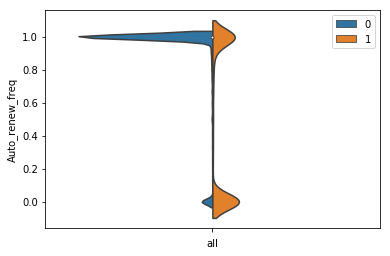

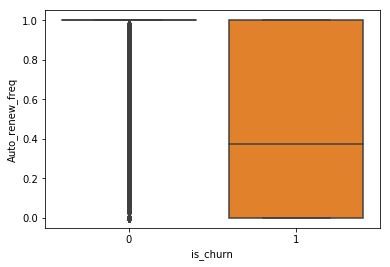

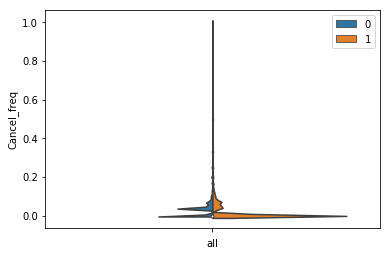

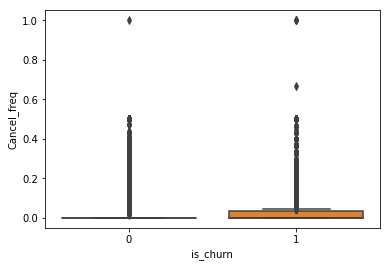

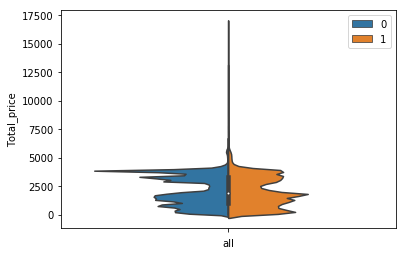

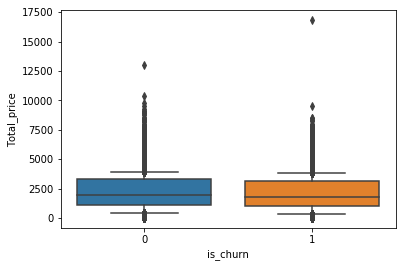

In [200]:
# Exploring variable influence for transactions

data=train.join(transactions_data, how="inner")
data["all"] = ""
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0)
plt.show()

for c in [
    "Latest_transaction",
    "Planned_membership_expiration",
    "Mean_transaction_duration",
    "Auto_renew_freq",
    "Cancel_freq",
    "Total_price"
]:
    sns.violinplot(hue="is_churn", x="all", y=c, data=data, split=True)
    plt.legend(loc="best")
    plt.show()
    
    sns.boxplot(x="is_churn", y=c, data=data)
    plt.legend(loc="best")
    plt.show()

In [165]:
# Grouping user logs
grouped_logs = user_logs.groupby("msno")
grouped_logs_last30 = user_logs[user_logs["date"] > pd.Timestamp(2017, 2, 1)].groupby("msno")

In [166]:
# Latest log
latest_logs = grouped_logs.max().loc[:, ["date"]].apply(feat.count_days)
# Number of logs
logs_count = grouped_logs.count().loc[:, ["date"]]
logs_count_last30 = grouped_logs_last30.count().loc[:, ["date"]]

In [167]:
logs_data = pd.DataFrame(index = latest_logs.index)
logs_data["Latest_log"] = latest_logs
logs_data["Logs_count"] = logs_count
logs_data["Logs_count_last30"] = logs_count_last30
logs_data["Log_last10"] = (latest_logs > -10).astype(int)
logs_data["Log_last30"] = (latest_logs > -30).astype(int)
logs_data["Log_last60"] = (latest_logs > -60).astype(int)
logs_data["Log_last90"] = (latest_logs > -90).astype(int)

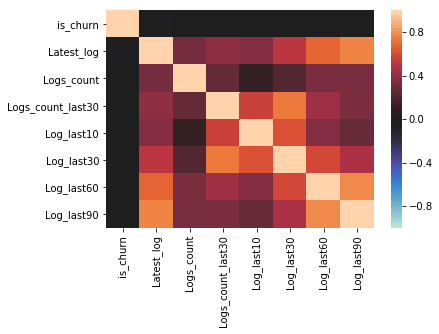

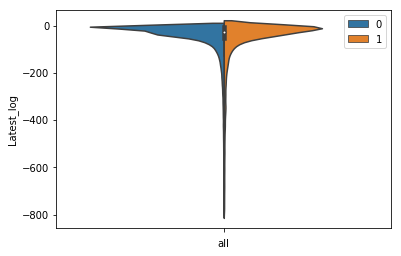

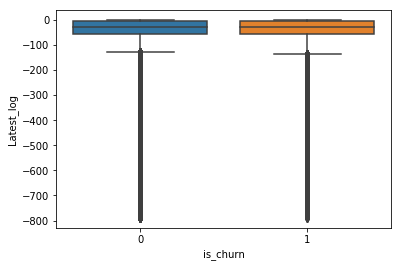

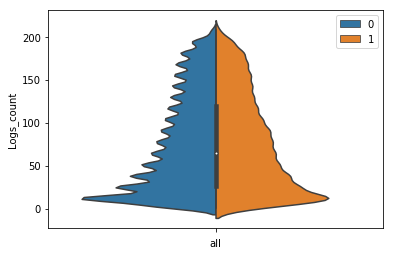

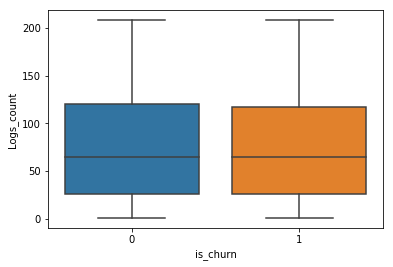

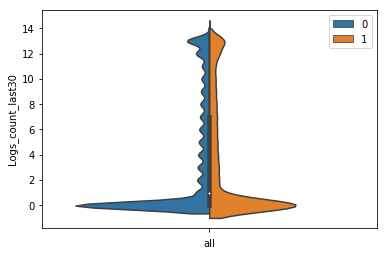

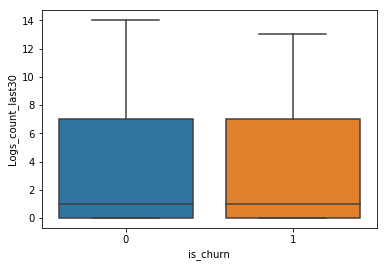

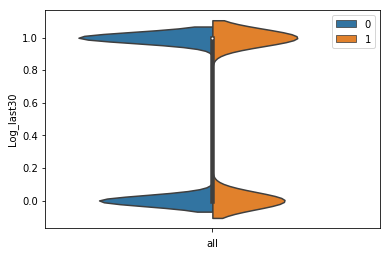

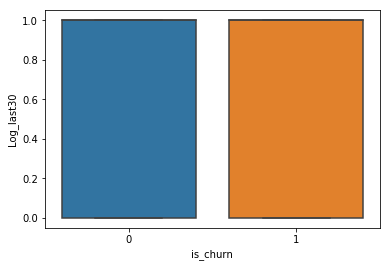

In [199]:
data = train.join([logs_data], how="inner")
data["all"] = ""
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0)
plt.show()

for c in [
    "Latest_log",
    "Logs_count",
    "Logs_count_last30",
    "Log_last30"
]:
    sns.violinplot(hue="is_churn", x="all", y=c, data=data, split=True)
    plt.legend(loc="best")
    plt.show()
    
    sns.boxplot(x="is_churn", y=c, data=data)
    plt.legend(loc="best")
    plt.show()